In [18]:
from scipy.stats import uniform
import datetime

import pandas as pd
import numpy as np

import json
import os

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import ParameterSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

# Model import
import lightgbm as lgb
from lightgbm import LGBMClassifier

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

<span style="font-size:1.5em;">Settings and pre-execution analysis functions</span>

In [19]:
DESIGN_NAME = "opentitan"
DESIGN = DESIGN_NAME.lower()
REPO_PATH = "/mnt/shared-scratch/Hu_J/minh.luu/github/vcdiag_opentitan"

DATA_ANALYSIS_PATH = f"{REPO_PATH}/data_analysis"
CONFIG_PATH = f"{REPO_PATH}/configs/{DESIGN}.json"
FINAL_BUG_DATA_PATH_TRAIN = f"{DATA_ANALYSIS_PATH}/data/final_data/train/"
FINAL_BUG_DATA_PATH_TEST = f"{DATA_ANALYSIS_PATH}/data/final_data/test/"

In [20]:
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)
sim_and_extract_config = config["sim_and_extract"]
extract_config = sim_and_extract_config["extract"]
BEFORE_FAILURE_TIMEFRAME = extract_config["line_limit"]
label_mapping = config["general"]["label_mapping"]

In [21]:
# Count the frequency of each label in the train label.csv
def count_label_frequency(label_file_path):
    label_freq = {}
    with open(label_file_path, 'r') as f:
        for line in f:
            label = line.split(',')[1].strip()
            if label not in label_freq:
                label_freq[label] = 1
            else:
                label_freq[label] += 1
    return label_freq


display(count_label_frequency(FINAL_BUG_DATA_PATH_TRAIN + "label.csv"))
display(count_label_frequency(FINAL_BUG_DATA_PATH_TEST + "label.csv"))

{'ACICONFSM': 2669,
 'ACICON': 2684,
 'AESCNR': 1782,
 'AESCNRFSM': 2768,
 'PRNGCLR': 3066,
 'AESKEYEXP': 3567,
 'MIXSINGCOL': 4079}

{'ACICONFSM': 184,
 'ACICON': 474,
 'AESCNR': 228,
 'AESCNRFSM': 365,
 'PRNGCLR': 347,
 'AESKEYEXP': 385,
 'MIXSINGCOL': 303}

<span style="font-size:1.5em;">Support classes and functions</span>

In [22]:
class StopExecution(Exception):
    def _render_traceback_(self):
        return []

<span style="font-size:1.5em;">Training</span>

<span style="font-size:1em;">Data import and preprocess</span>

In [23]:
# Read training data from csv
X_train = pd.read_csv(f"{FINAL_BUG_DATA_PATH_TRAIN}/data.csv")
label_train_df = pd.read_csv(
    f"{FINAL_BUG_DATA_PATH_TRAIN}/label.csv", index_col=0, header=None)
y_train = label_train_df.to_numpy().flatten()

# Read testing data from csv
X_test = pd.read_csv(f"{FINAL_BUG_DATA_PATH_TEST}/data.csv")

label_test_df = pd.read_csv(
    f"{FINAL_BUG_DATA_PATH_TEST}/label.csv", index_col=0, header=None)
y_test = label_test_df.to_numpy().flatten()

# Drop column "instances" for both training and testing data
X_train = X_train.drop(columns=["instances"])
X_test = X_test.drop(columns=["instances"])

X_train_original = X_train.copy()
X_test_original = X_test.copy()
y_train_original = label_train_df.to_numpy().flatten()
y_test_original = label_test_df.to_numpy().flatten()

In [24]:
X_train = X_train_original.copy()
X_test = X_test_original.copy()
y_train = y_train_original.copy()
y_test = y_test_original.copy()

print(f"Label mapping: {label_mapping}")

# Convert the labels to the corresponding values in the label_mapping
for i in range(len(y_train)):
    y_train[i] = label_mapping[y_train[i]]
for i in range(len(y_test)):
    y_test[i] = label_mapping[y_test[i]]

# cap the training dataset at 200 samples per class
X_train = X_train.copy()
y_train = y_train.copy()
X_train["label"] = y_train
X_train = X_train.groupby("label").head(3000)
y_train = X_train["label"]
X_train = X_train.drop(columns=["label"])

label_freq_train = {}
for label in y_train:
    if label not in label_freq_train:
        label_freq_train[label] = 1
    else:
        label_freq_train[label] += 1
        
label_freq_test = {}
for label in y_test:
    if label not in label_freq_test:
        label_freq_test[label] = 1
    else:
        label_freq_test[label] += 1
       
display(label_freq_train)
display(label_freq_test)

Label mapping: {'ACICONFSM': 'CipherControlFSM', 'ACICON': 'CipherControl', 'AESCNR': 'AESControl', 'AESCNRFSM': 'AESControlFSM', 'PRNGCLR': 'RegisterClearing', 'AESKEYEXP': 'KeyExpand', 'MIXSINGCOL': 'MixSingleColumn'}


{'CipherControlFSM': 2669,
 'CipherControl': 2684,
 'AESControl': 1782,
 'AESControlFSM': 2768,
 'RegisterClearing': 3000,
 'KeyExpand': 3000,
 'MixSingleColumn': 3000}

{'CipherControlFSM': 184,
 'CipherControl': 474,
 'AESControl': 228,
 'AESControlFSM': 365,
 'RegisterClearing': 347,
 'KeyExpand': 385,
 'MixSingleColumn': 303}

In [25]:
# convert all labels to float
le = LabelEncoder()
y_train_float = le.fit_transform(y_train)
y_test_float = le.transform(y_test)

# prep stats
classes = np.unique(y_train_float)
n_classes = len(classes)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_float
)

display(f"Weights: {class_weights}")
class_weights = {i: class_weights[i] for i in range(n_classes)}
max_delta_step = 1

'Weights: [1.51539202 0.97558836 1.00612093 1.01177541 0.90014286 0.90014286\n 0.90014286]'

In [26]:
columns_to_drop = [name for name in X_train.columns if any([name.endswith(suffix) for suffix in ["_kurt"]])]

X_train = X_train.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)

In [27]:
display(X_train.head())
display(X_train.shape)
display(y_train)

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_246,embedding_247,embedding_248,embedding_249,embedding_250,embedding_251,embedding_252,embedding_253,embedding_254,embedding_255
0,72048320.0,95101460.0,34070536.0,391361380.0,722869950.0,160645400.0,40895450.0,122635640.0,251170850.0,154949950.0,...,152661070.0,88237896.0,64509810.0,105896310.0,50418256.0,32340948.0,122871690.0,193124860.0,317898240.0,525626340.0
1,49871790.0,140172290.0,35522890.0,132430080.0,489511550.0,37565252.0,86625760.0,155254200.0,65435676.0,108167736.0,...,42927736.0,85654060.0,78877864.0,82525030.0,20568220.0,32905362.0,84707900.0,42805910.0,248683020.0,437753470.0
2,189625120.0,160778820.0,82880190.0,386294140.0,815803500.0,231285760.0,284833250.0,326581900.0,236574930.0,168370340.0,...,222055120.0,253829550.0,75924710.0,163361010.0,-315151600.0,47402980.0,-53261160.0,301102400.0,339766980.0,600238660.0
3,105082984.0,54324000.0,124684960.0,233022700.0,650076600.0,270802720.0,89019100.0,98807920.0,284919520.0,160693600.0,...,96134610.0,95062720.0,59264080.0,99516344.0,63459096.0,35985064.0,114018970.0,238963040.0,321316300.0,442877600.0
4,152552380.0,180552500.0,45459576.0,424302340.0,759841600.0,272514240.0,201569660.0,256225330.0,184188750.0,118409860.0,...,191373420.0,225293100.0,95326800.0,232048620.0,-186229980.0,-3436154.0,-102588020.0,114139250.0,364930900.0,546751100.0


(18903, 256)

0        CipherControlFSM
1        CipherControlFSM
2        CipherControlFSM
3        CipherControlFSM
4        CipherControlFSM
5        CipherControlFSM
6        CipherControlFSM
7        CipherControlFSM
8        CipherControlFSM
9        CipherControlFSM
10       CipherControlFSM
11       CipherControlFSM
12       CipherControlFSM
13       CipherControlFSM
14       CipherControlFSM
15       CipherControlFSM
16       CipherControlFSM
17       CipherControlFSM
18       CipherControlFSM
19       CipherControlFSM
20       CipherControlFSM
21       CipherControlFSM
22       CipherControlFSM
23       CipherControlFSM
24       CipherControlFSM
25       CipherControlFSM
26       CipherControlFSM
27       CipherControlFSM
28       CipherControlFSM
29       CipherControlFSM
30       CipherControlFSM
31       CipherControlFSM
32       CipherControlFSM
33       CipherControlFSM
34       CipherControlFSM
35       CipherControlFSM
36       CipherControlFSM
37       CipherControlFSM
38       Cip

<span style="font-size:1em;">ML model definition and training</span>

In [28]:
import torch
cuda_available = torch.cuda.is_available()
device = 'cpu' if not cuda_available else 'cuda'
display(device)

'cuda'

In [29]:
# LightGBM parameters
lightgbm_params = {
    'objective': 'multiclass',
    'boosting_type': 'gbdt',
    'num_class': n_classes,
    'verbose': -1,
    'device_type': device,
    'metric': 'multi_logloss',
    'tree_method': 'gpu_hist' if cuda_available else 'auto',
    'predictor': 'gpu_predictor' if cuda_available else 'cpu_predictor',
    # 'n_jobs': -1,
}

model = LGBMClassifier(**lightgbm_params)
eval_set = [(X_train, y_train_float), (X_test, y_test_float)]

model.fit(X_train, y_train_float, eval_set=eval_set)

LGBMClassifier(device_type='cuda', metric='multi_logloss', num_class=7,
               objective='multiclass', predictor='gpu_predictor',
               tree_method='gpu_hist', verbose=-1)

In [30]:
# convert all labels to float
le = LabelEncoder()
y_train_float = le.fit_transform(y_train)
y_test_float = le.transform(y_test)

# prep stats
classes = np.unique(y_train_float)
n_classes = len(classes)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_float
)
class_weights = {i: class_weights[i] for i in range(n_classes)}
max_delta_step = 1

<span style="font-size:1.5em;">Testing</span>

In [31]:
y_pred_bin = model.predict(X_test)
y_pred = le.inverse_transform(y_pred_bin)
y_pred_proba = model.predict_proba(X_test)

0.23140857392825898
0.541994750656168


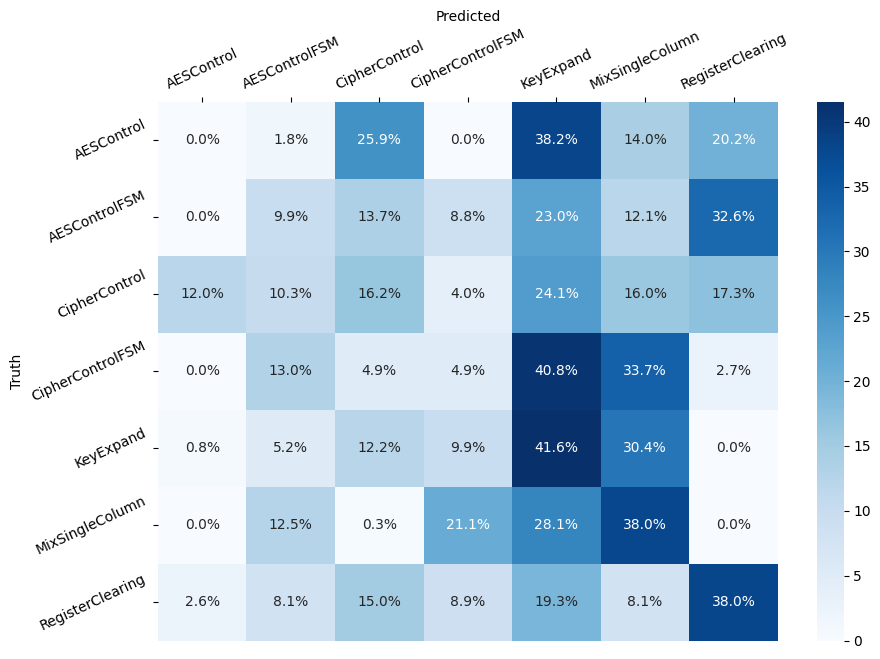

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, top_k_accuracy_score

acs = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cr = classification_report(y_test, y_pred, digits=4, output_dict=True)
top3_acs = top_k_accuracy_score(y_test, y_pred_proba, k=3 if n_classes > 3 else n_classes)

print(acs)
print(top3_acs)

# Convert integer labels for the confusion matrix to string labels
labels = np.unique(y_train)

# Plot confusion matrix with seaborn
plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm, annot=True, fmt=".1f", cmap='Blues',
                 xticklabels=labels, yticklabels=labels)
# Add % sign to heatmap
for t in ax.texts:
    t.set_text(t.get_text() + "%")
plt.xticks(ticks=np.arange(len(labels)) + 0.5, labels=labels)
plt.yticks(ticks=np.arange(len(labels)) + 0.5, labels=labels)
plt.xlabel('Predicted')
plt.ylabel('Truth')

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.tick_params(axis='x', rotation=25)

ax.yaxis.tick_left()
ax.yaxis.set_label_position('left')
ax.tick_params(axis='y', rotation=25)


# Save the confusion matrix and classification report to a file
# Create a folder to store the logs if it does not exist
if not os.path.exists(f"{DATA_ANALYSIS_PATH}/logs/ml_metrics_logs"):
    os.makedirs(f"{DATA_ANALYSIS_PATH}/logs/ml_metrics_logs")
plt.savefig(f"{DATA_ANALYSIS_PATH}/logs/ml_metrics_logs/cm_lgbm_{BEFORE_FAILURE_TIMEFRAME}_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.png", bbox_inches='tight', dpi=150)
# round to 4 decimal places for better readability
cr_df = pd.DataFrame(cr).transpose().round(4)
cr_df.to_csv(f"{DATA_ANALYSIS_PATH}/logs/ml_metrics_logs/cr_lgbm_{BEFORE_FAILURE_TIMEFRAME}_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv")

In [33]:
# Create a DataFrame to display the probabilities in a more descriptive way
df_prob = pd.DataFrame(y_pred_proba, columns=[
                       f'{class_name}_prob' for class_name in le.classes_])
df_prob['True_Label'] = y_test
df_prob['Predicted_Label'] = y_pred

# Inverse transform the labels
# df_prob['True_Label'] = le.inverse_transform(df_prob['True_Label'])
# df_prob['Predicted_Label'] = le.inverse_transform(df_prob['Predicted_Label'])

# Show only misclassified instances
df_prob = df_prob[df_prob['True_Label'] != df_prob['Predicted_Label']]

# Print the entire DataFrame
pd.set_option('display.max_rows', None)
display(df_prob)

,AESControl_prob,AESControlFSM_prob,CipherControl_prob,CipherControlFSM_prob,KeyExpand_prob,MixSingleColumn_prob,RegisterClearing_prob,True_Label,Predicted_Label
0,0.001237,0.069780,0.036592,0.127016,0.145467,0.619262,6.448510e-04,CipherControlFSM,MixSingleColumn
1,0.002224,0.070652,0.022778,0.014782,0.610013,0.278035,1.516099e-03,CipherControlFSM,KeyExpand
2,0.001460,0.022282,0.030502,0.026454,0.426750,0.491712,8.403168e-04,CipherControlFSM,MixSingleColumn
3,0.000774,0.016430,0.015615,0.026725,0.669093,0.271260,1.030796e-04,CipherControlFSM,KeyExpand
4,0.009568,0.156337,0.320868,0.017959,0.460927,0.033963,3.778552e-04,CipherControlFSM,KeyExpand
5,0.007410,0.125972,0.308565,0.046374,0.277017,0.232948,1.715065e-03,CipherControlFSM,CipherControl
6,0.020551,0.042685,0.280494,0.048578,0.468570,0.137552,1.569763e-03,CipherControlFSM,KeyExpand
7,0.004924,0.111233,0.384417,0.103508,0.157831,0.236403,1.685358e-03,CipherControlFSM,CipherControl
8,0.001358,0.067173,0.026838,0.094051,0.203414,0.605514,1.652530e-03,CipherControlFSM,MixSingleColumn
9,0.001994,0.161076,0.041645,0.016659,0.680594,0.097235,7.978506e-04,CipherControlFSM,KeyExpand


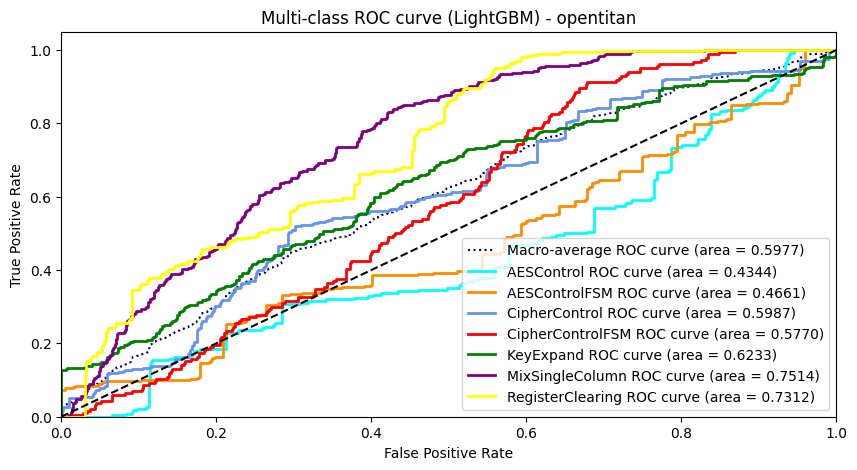

In [34]:
# Graph multi-class ROC curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

n_classes = len(count_label_frequency(FINAL_BUG_DATA_PATH_TRAIN + "label.csv"))
class_names = le.classes_
y_test_bin = label_binarize(y_test, classes=class_names)
y_pred_bin = y_pred_proba

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 5))
plt.plot(fpr["macro"], tpr["macro"], label="Macro-average ROC curve (area = {:.4f})".format(roc_auc["macro"]), color="navy", linestyle=":")
colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green", "purple", "yellow", "brown", "pink", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label="{0} ROC curve (area = {1:.4f})".format(class_names[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Multi-class ROC curve (LightGBM) - {DESIGN_NAME}")
plt.legend(loc="lower right")

# Save the ROC curve
plt.savefig(f"{DATA_ANALYSIS_PATH}/logs/ml_metrics_logs/roc_lgbm_{BEFORE_FAILURE_TIMEFRAME}_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.png", bbox_inches='tight', dpi=150)

plt.show()